# Data and Imports

In [102]:
from UNetPyTorch import *

import xarray as xr
import numpy as np
import pandas as pd

import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from datetime import datetime

import cartopy
import cartopy.crs as ccrs

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.utils import from_networkx

from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader

from torch.utils.data import DataLoader, Dataset

from IPython.display import HTML

from typing import Tuple, Optional

ds = xr.open_dataset('data_850/2022_850_SA_coarsen.nc')
ds.load()

<xarray.Dataset> Size: 197MB
Dimensions:    (time: 8760, latitude: 16, longitude: 32)
Coordinates:
  * time       (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T23:00:00
  * longitude  (longitude) float32 128B 16.31 16.81 17.31 ... 30.81 31.31 31.81
  * latitude   (latitude) float32 64B -34.89 -34.39 -33.89 ... -27.89 -27.39
Data variables:
    q          (time, latitude, longitude) float64 36MB 0.007599 ... 0.009553
    t          (time, latitude, longitude) float64 36MB 282.4 282.5 ... 284.3
    u          (time, latitude, longitude) float64 36MB 14.09 13.71 ... 3.188
    v          (time, latitude, longitude) float64 36MB -0.8432 -1.022 ... 4.144
    w          (time, latitude, longitude) float64 36MB -0.002005 ... 0.1457
    wspd       (time, latitude, longitude) float32 18MB 14.12 13.75 ... 5.228
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-28 12:36:03 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...
    wspd_units:   m/s

In [103]:
class WeatherData(Dataset):

    """
    A dataset class for preparing wind speed data for machine learning models.

    Attributes:
        dataset (xr.Dataset): The xarray dataset containing wind speed data.
        window_size (int): The size of the window for creating features.
        steps (int): The number of forecasting steps.
        use_forcings (bool): Flag to indicate whether to use forcings.
        features (np.ndarray): Array of feature data.
        targets (np.ndarray): Array of target data.
        forcings (np.ndarray): Array of forcing data.
        time_values (np.ndarray): Array of time values corresponding to features.
        min_value (float): Minimum wind speed value for normalization.
        max_value (float): Maximum wind speed value for normalization.
        mean_value (float): Mean wind speed value for normalization.
        std_value (float): Standard deviation of wind speed for normalization.
        X_train (np.ndarray): Training features.
        X_test (np.ndarray): Testing features.
        y_train (np.ndarray): Training targets.
        y_test (np.ndarray): Testing targets.
        F_train (np.ndarray): Training forcings.
        F_test (np.ndarray): Testing forcings.
        X_train_t (torch.Tensor): Normalized training features as tensors.
        y_train_t (torch.Tensor): Normalized training targets as tensors.
        X_test_t (torch.Tensor): Normalized testing features as tensors.
        y_test_t (torch.Tensor): Normalized testing targets as tensors.
        F_train_t (torch.Tensor): Training forcings as tensors.
        F_test_t (torch.Tensor): Testing forcings as tensors.
    """

    def __init__(self, dataset: xr.Dataset, window_size: int = 24, steps: int = 3, auto = False, use_forcings = False, intervals = 1):

        """
        Initializes the WeatherData object.

        Args:
            dataset (xr.Dataset): The xarray dataset containing wind speed data.
            window_size (int): The size of the window for creating features. Default is 24.
            steps (int): The number of forecasting steps. Default is 3.
            auto (bool): Flag to automatically window and normalize data. Default is False.
            use_forcings (bool): Flag to indicate whether to use forcings. Default is False.
        """
        
        self.dataset = dataset
        self.window_size = window_size
        self.steps = steps
        self.calculate_wind_speed()
        self.dataset = self.dataset.sortby('latitude')

        self.min_value = self.dataset.wspd.min().item()
        self.max_value = self.dataset.wspd.max().item()

        self.mean_value = self.dataset.wspd.mean().item()
        self.std_value = self.dataset.wspd.std().item()

        self.use_forcings = use_forcings

        if auto:
            if intervals > 1:
                self.time_intervals(intervals)
            self.window_dataset()
            self.split_data()    
            self.normalize_data()    

    def __len__(self) -> int:

        """
        Returns the length of the training dataset.

        Returns:
            int: The number of samples in the training dataset.
        """

        return len(self.X_train)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:

        """
        Retrieves a sample from the dataset.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: A tuple containing features, forcings, and target.
        """

        return self.X_train_t[idx], self.F_train_t[idx], self.y_train_t[idx, 0].reshape(1, self.dataset.sizes['latitude'], self.dataset.sizes['longitude'])
    
    def time_intervals(self, intervals: int = 3) -> None:
    
        """
        Subsets the dataset based on the specified time intervals. Only happens once and then dataset is saved as a .nc file.

        Args:
            intervals (int): The time intervals for subsetting. Default is 3.

        Returns:
            None: Updates the dataset in place.
        """

        self.dataset = self.dataset.sel(time=slice(None, None, intervals))

    def subset_data(self, coarsen: int = 1) -> None:

        """
        Subsets the dataset based on the specified coarsening factor. Only happens once and then dataset is saved as a .nc file.

        Args:
            coarsen (int): The coarsening factor for subsetting. Default is 1.

        Returns:
            None: Updates the dataset in place.
        """

        if coarsen > 1:
            lat_slice = slice(1, 33, coarsen)
            lon_slice = slice(3, 67, coarsen)
        else:
            lat_slice = slice(1, 33)  
            lon_slice = slice(3, 67)

        self.dataset = self.dataset.isel(latitude=lat_slice, longitude=lon_slice)

    def calculate_wind_speed(self) -> None:
        """
        Calculates wind speed from u and v components and adds it to the dataset.

        Returns:
            None: Updates the dataset in place with the wind speed variable.
        """

        self.dataset['wspd'] = np.sqrt(self.dataset.u**2 + self.dataset.v**2).astype(np.float32)
        self.dataset.attrs['wspd_units'] = 'm/s'
        # self.dataset['wdir'] = np.arctan2(self.dataset.v, self.dataset.u) * 180 / np.pi
        # self.dataset.attrs['wdir_units'] = 'degrees'

    def window_dataset(self, variable: str = 'wspd') -> None:

        """
        Creates windows of features and targets from the dataset.

        Args:
            variable (str): The variable to use for feature extraction. Defaults to 'wspd'.

        Returns:
            None: Updates the instance attributes with the created windows.
        """

        time_dim = self.dataset.sizes['time']
        total_windows = time_dim - self.window_size - self.steps

        # Preallocate arrays for better performance
        features = np.empty((total_windows, self.window_size, self.dataset.sizes['latitude'], self.dataset.sizes['longitude']), dtype=np.float32)
        targets = np.empty((total_windows,  self.steps, self.dataset.sizes['latitude'], self.dataset.sizes['longitude']), dtype=np.float32)
        forcings = np.empty((total_windows, 2), dtype=np.int32)
        time_values = np.empty((total_windows, self.window_size), dtype='datetime64[ns]')

        # Slice the dataset for all the time values at once
        dataset_time = self.dataset.time.values
        dataset_hour = self.dataset.time.dt.hour.values
        dataset_month = self.dataset.time.dt.month.values

        # Vectorized slicing
        for i in range(total_windows):
            print(f'{i}/{total_windows}', end='\r')
            
            # Slice features, targets, time values, and forcings in batches
            features[i] = self.dataset[variable].isel(time=slice(i, i + self.window_size)).values
            targets[i] = self.dataset[variable].isel(time=slice(i + self.window_size, i + self.window_size + self.steps)).values
            time_values[i] = dataset_time[i:i + self.window_size]

            # Hour and month forcings
            forcings[i] = [dataset_hour[i + self.window_size], dataset_month[i + self.window_size]]

        # Save arrays as attributes
        self.features = features
        self.targets = targets
        self.forcings = forcings
        self.time_values = time_values

        print('Windowed...')

    def split_data(self, test_size: float = 0.2, random_state: int = 42) -> None:
        """
        Splits the data into training and testing sets.

        Args:
            test_size (float): Proportion of the dataset to include in the test split. Default is 0.2.
            random_state (int): Random seed for reproducibility. Default is 42.

        Returns:
            None: Updates the instance attributes with training and testing sets.
        """
        """
        Splits the data into training, validation, and test sets.
        """

        print('Splitting...')
        self.X_train, self.X_test, self.y_train, self.y_test, self.F_train, self.F_test, self.T_train, self.T_test = train_test_split(
            self.features, self.targets, self.forcings, self.time_values,
            test_size= test_size)
     
        print('Shuffling...')
        
        self.X_train, self.y_train, self.F_train, self.T_train = shuffle(self.X_train, self.y_train, self.F_train, self.T_train, random_state=random_state)

    def normalize_data(self) -> None:
        """
        Normalizes the training and testing data using mean and standard deviation.

        Returns:
            None: Updates the instance attributes with normalized data as tensors.
        """

        # Normalize the data with standard deviation
        self.X_train_t = (self.X_train - self.mean_value) / self.std_value
        self.y_train_t = (self.y_train - self.mean_value) / self.std_value

        self.X_test_t = (self.X_test - self.mean_value) / self.std_value
        self.y_test_t = (self.y_test - self.mean_value) / self.std_value

        # To tensors
        self.X_train_t = torch.tensor(self.X_train_t).float()
        self.y_train_t = torch.tensor(self.y_train_t).float()
        
        self.X_test_t = torch.tensor(self.X_test_t).float()
        self.y_test_t = torch.tensor(self.y_test_t).float()

        self.F_train_t = torch.tensor(self.F_train).float()
        self.F_test_t = torch.tensor(self.F_test).float()

    def plot_from_ds(self, seed: int = 0, frame_rate: int = 16, levels: int = 10) -> HTML:
        """
        Plots features and targets from the dataset for visualization.

        Args:
            seed (int): Seed for reproducibility in selecting samples. Default is 0.
            frame_rate (int): The frame rate for the animation. Default is 16.
            levels (int): Number of contour levels for the plot. Default is 10.

        Returns:
            HTML: An HTML object representing the animation.
        """
        bounds = [self.dataset.longitude.min().item(), self.dataset.longitude.max().item(), self.dataset.latitude.min().item(), self.dataset.latitude.max().item()]
        features = self.features[seed]
        targets = self.targets[seed]
        time_values = self.time_values

        fig, axs = plt.subplots(1, 2, figsize=(21, 7), subplot_kw={'projection': ccrs.PlateCarree()})

        vmin = min(features.min().item(), targets.min().item())
        vmax = max(features.max().item(), targets.max().item())

        fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.2)

        for ax in axs:
            ax.set_extent(bounds, crs=ccrs.PlateCarree())
            ax.coastlines()


        feat = axs[0].contourf(self.dataset.longitude, self.dataset.latitude, features[0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        tar = axs[1].contourf(self.dataset.longitude, self.dataset.latitude, targets[0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        axs[1].set_title('Target')

        fig.colorbar(feat, ax=axs[0], orientation='vertical', label='Wind Speed (m/s)')
        fig.colorbar(tar, ax=axs[1], orientation='vertical', label='Wind Speed (m/s)')

        def animate(i):
            axs[0].clear()
            axs[0].coastlines()

            pcm = axs[0].contourf(self.dataset.longitude, self.dataset.latitude, features[i], levels=levels, vmin=vmin, vmax = vmax)
            

            start_time = time_values[i][0]
            end_time = time_values[i][-1]

            start_time = pd.to_datetime(start_time)
            end_time = pd.to_datetime(end_time)

            axs[0].set_title(f'Window {i} - {start_time.strftime("%Y-%m-%d %H:%M:%S")} to {end_time.strftime("%Y-%m-%d %H:%M:%S")}')
            if self.steps > 1:
                ptm = axs[1].contourf(self.dataset.longitude, self.dataset.latitude, targets[i % self.steps], levels=levels, vmin=vmin, vmax = vmax)
                axs[1].set_title(f'Target - {end_time.strftime("%Y-%m-%d %H:%M:%S")}')
            return pcm

            
        frames = features.shape[0]

        interval = 1000 / frame_rate

        ani = FuncAnimation(fig, animate, frames=frames, interval=interval)

        plt.close(fig)

        return HTML(ani.to_jshtml())

    def plot_from_data(self, seed: int = 0, frame_rate: int = 16, levels: int = 10) -> HTML:
        """
        Plots features and targets from the windowed arrays for visualization.

        Args:
            seed (int): Seed for reproducibility in selecting samples. Default is 0.
            frame_rate (int): The frame rate for the animation. Default is 16.
            levels (int): Number of contour levels for the plot. Default is 10.

        Returns:
            HTML: An HTML object representing the animation.
        """
        bounds = [self.dataset.longitude.min().item(), self.dataset.longitude.max().item(), self.dataset.latitude.min().item(), self.dataset.latitude.max().item()]
        features = self.X_test[seed:seed+1]
        targets = self.y_test[seed:seed+1]
        time_values = self.time_values

        features = features * (self.max_value - self.min_value) + self.min_value
        targets = targets * (self.max_value - self.min_value) + self.min_value

        fig, axs = plt.subplots(1, 2, figsize=(21, 7), subplot_kw={'projection': ccrs.PlateCarree()})

        vmin = min(features.min().item(), targets.min().item())
        vmax = max(features.max().item(), targets.max().item())

        fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.2)

        for ax in axs:
            ax.set_extent(bounds, crs=ccrs.PlateCarree())
            ax.coastlines()


        feat = axs[0].contourf(self.dataset.longitude, self.dataset.latitude, features[0,0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        tar = axs[1].contourf(self.dataset.longitude, self.dataset.latitude, targets[0,0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        axs[1].set_title('Target')

        fig.colorbar(feat, ax=axs[0], orientation='vertical', label='Wind Speed (m/s)')
        fig.colorbar(tar, ax=axs[1], orientation='vertical', label='Wind Speed (m/s)')

        def animate(i):
            axs[0].clear()
            axs[0].coastlines()

            pcm = axs[0].contourf(self.dataset.longitude, self.dataset.latitude, features[0,i], levels=levels, vmin=vmin, vmax = vmax)
            

            start_time = time_values[i][0]
            end_time = time_values[i][-1]

            start_time = pd.to_datetime(start_time)
            end_time = pd.to_datetime(end_time)

            axs[0].set_title(f'Window {i} - {start_time.strftime("%Y-%m-%d %H:%M:%S")} to {end_time.strftime("%Y-%m-%d %H:%M:%S")}')
            if self.steps > 1:
                ptm = axs[1].contourf(self.dataset.longitude, self.dataset.latitude, targets[0,i % self.steps], levels=levels, vmin=vmin, vmax = vmax)
                axs[1].set_title(f'Target - {end_time.strftime("%Y-%m-%d %H:%M:%S")}')
            return pcm

            
        frames = features.shape[1]

        interval = 1000 / frame_rate

        ani = FuncAnimation(fig, animate, frames=frames, interval=interval)

        plt.close(fig)

        return HTML(ani.to_jshtml())


# Graph state representation

In [104]:
weather_data = WeatherData(ds, window_size=3, steps=1, auto=True, use_forcings=False)

Windowed...
Splitting...
Shuffling...


In [117]:
# Encoder functions

class MLPEncoder(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        """
        MLP to encode wind speed data from each state in the window.
        
        Args:
        input_dim (int): Dimension of the input feature (e.g., wind speed).
        hidden_dim (int): Dimension of the hidden layer.
        output_dim (int): Dimension of the output latent feature for each node.
        """
        super(MLPEncoder, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the MLP encoder.
        
        Args:
        x (torch.Tensor): Input tensor of shape [batch_size, latitude, longitude].
        
        Returns:
        torch.Tensor: Encoded tensor of shape [batch_size, latitude, longitude, output_dim].
        """
        # Flatten spatial dimensions and process through MLP
        batch_size, lat, lon = x.shape
        x_flat = x.view(batch_size, -1)  # Flatten lat, lon dimensions
        encoded = self.mlp(x_flat)
        # Reshape back to original spatial dimensions with new feature dim
        return encoded.view(batch_size, lat, lon, -1)
    
def generate_mesh(lat_size: np.ndarray = 16, lon_size: np.ndarray = 32) -> nx.Graph:
    """
    Generate a mesh based on latitude and longitude grid points using NetworkX.
    
    Args:
    lat (np.ndarray): Latitude values.
    lon (np.ndarray): Longitude values.
    connectivity (str): Either '4' or '8' to define the type of mesh connectivity (4 or 8 neighbors).
    
    Returns:
    nx.Graph: NetworkX graph representing the mesh structure.
    """
    # Create a graph and add nodes and edges for 4-connectivity (horizontal and vertical neighbors)
    G = nx.grid_2d_graph(lat_size, lon_size)

    # Add diagonal connections (8-connectivity)
    for i in range(lat_size):
        for j in range(lon_size):
            if i > 0 and j > 0:
                G.add_edge((i, j), (i-1, j-1))  # Top-left
            if i > 0 and j < lon_size - 1:
                G.add_edge((i, j), (i-1, j+1))  # Top-right
            if i < lat_size - 1 and j > 0:
                G.add_edge((i, j), (i+1, j-1))  # Bottom-left
            if i < lat_size - 1 and j < lon_size - 1:
                G.add_edge((i, j), (i+1, j+1))  # Bottom-right

    return G

def populate_mesh_with_features(mesh: nx.Graph, encoded_features: torch.Tensor) -> nx.Graph:
    """
    Populate the mesh with encoded wind speed features.
    
    Args:
    mesh (nx.Graph): The mesh containing nodes and edges.
    encoded_features (torch.Tensor): Encoded wind speed data of shape [latitude, longitude, feature_dim].
    
    Returns:
    nx.Graph: Updated mesh with node features.
    """

    batch, lat_size, lon_size, features = encoded_features.shape

    if batch == 1:
        encoded_features = encoded_features.squeeze().squeeze()
    node_value_dict = {(i, j): encoded_features[i, j].tolist() for i in range(lat_size) for j in range(lon_size)}

    nx.set_node_attributes(mesh, node_value_dict, name="value")

    return mesh

def create_meshes_for_window(window: torch.Tensor, encoder: nn.Module, lat: np.ndarray, lon: np.ndarray, encode: bool = True) -> list[dict]:
    """
    Create meshes for each state in the window and encode them.
    
    Args:
    window (torch.Tensor): Input window of shape [batch_size, window_size, latitude, longitude].
    encoder (nn.Module): The MLP encoder to encode wind speed data.
    lat (np.ndarray): Array of latitude values.
    lon (np.ndarray): Array of longitude values.
    connectivity (str): Mesh connectivity, either '4' or '8'.
    
    Returns:
    list[dict]: A list of meshes for each timestep in the window.
    """
    batch_size, window_size, lat_dim, lon_dim = window.shape
    meshes = []
    
    # Loop through each state in the window
    for t in range(window_size):
        wind_speed_state = window[:, t]  # Extract wind speed data at timestep t
        if encode:
            encoded_state = encoder(wind_speed_state)
        else:
            encoded_state = wind_speed_state.reshape(batch_size, lat_dim, lon_dim, 1)
        
        # Generate the mesh and populate it with features
        mesh = generate_mesh(lat, lon)
        populated_mesh = populate_mesh_with_features(mesh, encoded_state)
        meshes.append(populated_mesh)

    print(f'Nr meshes: {len(meshes)}, representing shape {encoded_state.shape}')
    
    return meshes

def plot_mesh(meshes, lat_size: int = 16, lon_size: int = 32):
    """Plot multiple meshes as subplots.

    Args:
        meshes: List of mesh graphs.
        positions: List of positions for each mesh.
        subplots: Number of subplots in the grid.
    """

    positions = {}
    for i in range(lat_size):
        for j in range(lon_size):
            positions[(i, j)] = (j, i)

    num_meshes = len(meshes)
    subplots = num_meshes
    
    # Determine number of rows and columns for subplots
    rows = (num_meshes // subplots) + (num_meshes % subplots > 0)
    cols = min(num_meshes, subplots)
    
    fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axs = axs.flatten()  # Flatten the array of axes for easy iteration

    for i in range(num_meshes):
        node_colors = [meshes[i].nodes[node]['value'] for node in meshes[i].nodes]
        nx.draw(meshes[i], pos=positions, node_size=30, node_color=node_colors, cmap=plt.cm.viridis, edge_color='gray', ax=axs[i], with_labels=False)
        axs[i].set_title(f"Mesh {i + 1} with Diagonal Connections")
    
    # Hide any unused subplots
    for j in range(num_meshes, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()


Nr meshes: 3, representing shape torch.Size([1, 16, 32, 1])


Nr meshes: 3, representing shape torch.Size([1, 16, 32, 1])


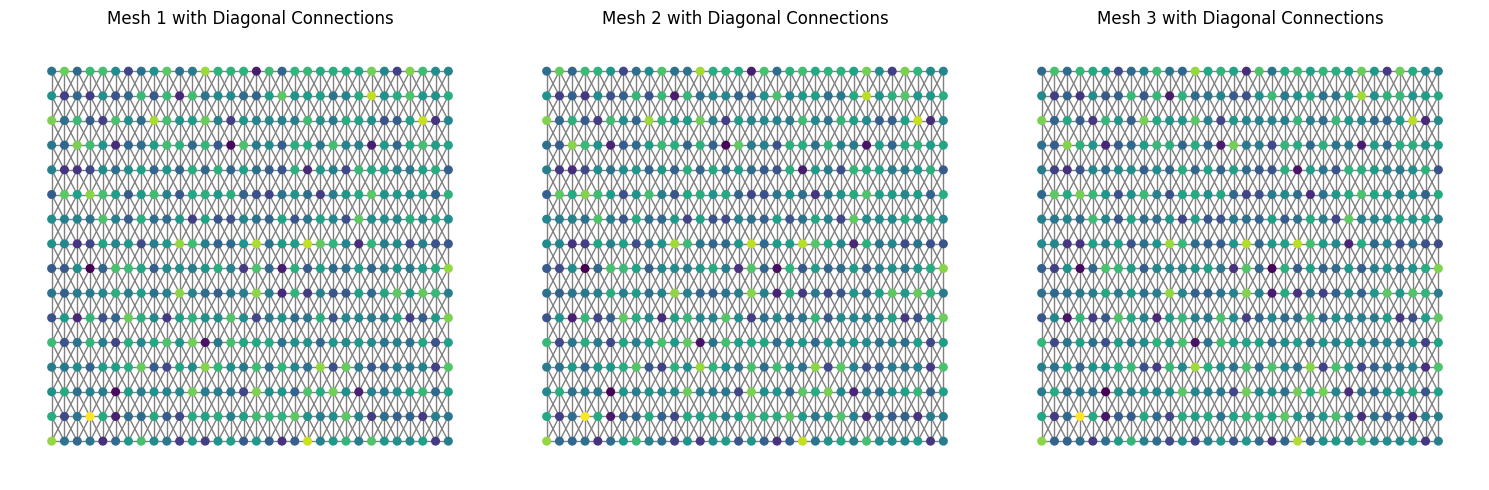

In [124]:
encoder_shape = weather_data.dataset.latitude.size * weather_data.dataset.longitude.size
encoder = MLPEncoder(input_dim=encoder_shape, hidden_dim=encoder_shape, output_dim=encoder_shape) 

meshes = create_meshes_for_window(weather_data.X_train_t[0:1], 
                                  encoder, weather_data.dataset.latitude.size, 
                                  weather_data.dataset.longitude.size)

plot_mesh(meshes)